In [1]:
#!/usr/bin/python3
# coding: utf-8
# prefectures

In [2]:
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib
import sys
if "ipy" not in sys.argv[0]:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.neighbors import LocalOutlierFactor
from japanmap import picture
import numpy as np
import os
import pandas as pd
from PIL import Image
from cov19utils import create_basic_plot_figure, \
    show_and_clear, moving_average, \
    blank2zero, csv2array, \
    get_twitter, tweet_with_image, \
    get_gpr_predict, FONT_NAME, DT_OFFSET, \
    download_if_needed, json2nparr, code2int, age2int

In [3]:
populations = {}
all_population = 0
with codecs.open("population.txt", encoding='utf-8') as f:
    l = f.readline()
    while l:
        elems = l.split(',')
        populations[elems[3]] = dict(
            region = int(elems[0]),
            code   = int(elems[1]),
            ja     = elems[2],
            en     = elems[3],
            total = int(elems[4])
        )
        all_population += int(elems[4])
        l = f.readline().replace("\r\n", "").rstrip()
print("All population in Japan: {}".format(all_population))

All population in Japan: 127094745


In [4]:
#print(populations)

In [5]:
# 全国情報
ogiwara_uri = "https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/"
pref_file = "prefectures.csv"
download_if_needed(ogiwara_uri, pref_file)

In [6]:
offsets = dict(
    year  = 0, # 年
    month = 1, # 月
    day   = 2, # 日
    st_ja = 3, # 都道府県
    st_en = 4, # state
    posis = 5, # 陽性者数
    tests = 6, # 検査数
    hospi = 7, # hospitalized
    serio = 8, # serious
    disch = 9, # discharged
    death =10, # deaths
    ern   =11, # Effective Reproduction Number
)

In [7]:
dt_start = dt.strptime("2020/2/8", "%Y/%m/%d") # 統計開始日
dt_now   = dt.now() # 現在日時
dt_delta = (dt_now - dt_start).days # 差分
n_states = 47 # 都道府県数
erns = [] # 実効再生産数
poss = [] # 陽性者数
test = [] # 検査数
for i in np.arange(dt_delta):
    erns.append(np.zeros(n_states+1).tolist())
    poss.append(np.zeros(n_states+1).tolist())
    test.append(np.zeros(n_states+1).tolist())
    test[i][0] = poss[i][0] = erns[i][0] = i

In [8]:
with codecs.open("prefectures.csv", encoding='utf-8') as f:
    l = f.readline()
    cnt = 0
    while l:
        l = f.readline().replace("\r\n", "").rstrip()
        elems = l.split(',')
        if len(elems) < 2:
            continue
        dt_idx  = (dt(int(elems[0]), int(elems[1]), int(elems[2])) - dt_start).days
        st_name = elems[offsets['st_en']]
        st_idx  = populations[st_name]['code']
        erns[dt_idx][st_idx] = blank2zero(elems[offsets['ern']])
        poss[dt_idx][st_idx] = blank2zero(elems[offsets['posis']])
        tested = blank2zero(elems[offsets['tests']])
        if tested > 0:
            test[dt_idx][st_idx] = tested
        cnt += 1
print("Load {} lines.".format(cnt))

Load 9960 lines.


In [9]:
erns = np.array(erns)
poss = np.array(poss)
test = np.array(test)

In [10]:
def get_os_idx_of_arr(arr, delta_days):
    os_idx = -1
    for i in np.arange(delta_days):
        if np.sum(arr[-i -1, 1:])  > 0:
            os_idx = -i -1
            print("Data offset index: {}".format(os_idx))
            break
    return os_idx

def dump_val_in_arr(arr, prefix, dec_num=1):
    print("{}: ".format(prefix), end="")
    for k, v in populations.items():
        strfmt = "{}={:." + str(dec_num) + "f} "
        print(strfmt.format(v['ja'], np.round(arr[v['code']], dec_num)), end="")
    print("")

In [11]:
os_idx = get_os_idx_of_arr(erns, dt_delta)
latest_erns = erns[os_idx] # 最新の実効再生産数
dump_val_in_arr(latest_erns, "最新の実効再生産数")

Data offset index: -1
最新の実効再生産数: 北海道=1.3 青森=1.0 岩手=0.0 宮城=1.2 秋田=0.0 山形=0.0 福島=0.9 茨城=1.2 栃木=0.6 群馬=1.7 埼玉=1.2 千葉=1.2 東京=1.0 神奈川=1.0 新潟=0.0 山梨=2.7 長野=2.7 岐阜=0.5 静岡=1.3 愛知=0.8 三重=1.0 富山=0.8 石川=0.2 福井=0.0 滋賀=0.4 京都=0.7 大阪=1.0 兵庫=1.3 奈良=1.1 和歌山=0.4 鳥取=0.0 島根=0.0 岡山=1.1 広島=0.9 山口=0.6 徳島=0.0 香川=0.0 愛媛=0.0 高知=0.0 福岡=1.1 佐賀=1.0 長崎=0.0 熊本=12.2 大分=0.0 宮崎=0.0 鹿児島=0.7 沖縄=1.5 


In [12]:
os_idx = get_os_idx_of_arr(poss, dt_delta)
latest_poss = poss[os_idx] # 最新の感染者数
dump_val_in_arr(latest_poss, "最新の感染者数", 0)

Data offset index: -1
最新の感染者数: 北海道=2217 青森=37 岩手=24 宮城=433 秋田=58 山形=78 福島=272 茨城=681 栃木=442 群馬=733 埼玉=4840 千葉=4110 東京=26727 神奈川=7212 新潟=170 山梨=195 長野=313 岐阜=631 静岡=558 愛知=5449 三重=530 富山=422 石川=778 福井=246 滋賀=507 京都=1791 大阪=10899 兵庫=2804 奈良=581 和歌山=242 鳥取=36 島根=140 岡山=161 広島=605 山口=204 徳島=149 香川=93 愛媛=115 高知=138 福岡=5057 佐賀=246 長崎=238 熊本=639 大分=158 宮崎=344 鹿児島=440 沖縄=2629 


In [13]:
def calc_last1w2w_dif(arr, name):
    idx = get_os_idx_of_arr(arr, dt_delta)
    latest_arr = arr[idx] # 最新
    last1w_arr = arr[idx -  7] # 1週間前
    last2w_arr = arr[idx - 14] # 2週間前
    diff1w_arr = latest_arr - last1w_arr # 最新と1週間前の差分
    diff2w_arr = latest_arr - last2w_arr # 最新と2週間前の差分
    dump_val_in_arr(diff1w_arr, "1週間{}".format(name), 0)
    dump_val_in_arr(diff2w_arr, "2週間{}".format(name), 0)
    return diff1w_arr, diff2w_arr

In [14]:
diff1w_poss, diff2w_poss = calc_last1w2w_dif(poss, "陽性者数")

Data offset index: -1
1週間陽性者数: 北海道=142 青森=1 岩手=1 宮城=36 秋田=5 山形=0 福島=21 茨城=29 栃木=14 群馬=34 埼玉=216 千葉=248 東京=1183 神奈川=393 新潟=0 山梨=12 長野=8 岐阜=8 静岡=24 愛知=140 三重=28 富山=5 石川=2 福井=2 滋賀=6 京都=52 大阪=365 兵庫=120 奈良=13 和歌山=1 鳥取=0 島根=0 岡山=7 広島=57 山口=3 徳島=2 香川=0 愛媛=1 高知=0 福岡=29 佐賀=1 長崎=2 熊本=66 大分=0 宮崎=0 鹿児島=25 沖縄=169 
2週間陽性者数: 北海道=242 青森=2 岩手=1 宮城=64 秋田=5 山形=0 福島=46 茨城=52 栃木=40 群馬=50 埼玉=378 千葉=441 東京=2333 神奈川=772 新潟=5 山梨=15 長野=10 岐阜=31 静岡=41 愛知=327 三重=55 富山=12 石川=18 福井=2 滋賀=28 京都=132 大阪=733 兵庫=202 奈良=25 和歌山=5 鳥取=0 島根=3 岡山=13 広島=126 山口=9 徳島=2 香川=0 愛媛=1 高知=1 福岡=53 佐賀=2 長崎=2 熊本=68 大分=0 宮崎=0 鹿児島=63 沖縄=265 


In [15]:
# 都道府県別 罹患率
incid1w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (1週足)
incid2w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (2週足)
incid_all_rate = np.zeros(n_states + 1).tolist() # 罹患率 (全期間)
for k, v in populations.items():
    i = v['code']
    incid1w_rate[i] = (diff1w_poss[i] / v['total']) * 100 # percentage
    incid2w_rate[i] = (diff2w_poss[i] / v['total']) * 100 # percentage
    incid_all_rate[i] = (latest_poss[i] / v['total']) * 100 # percentage

In [16]:
diff1w_test, diff2w_test = calc_last1w2w_dif(test, "検査数")

Data offset index: -1
1週間検査数: 北海道=3713 青森=104 岩手=239 宮城=758 秋田=119 山形=76 福島=1362 茨城=263 栃木=2233 群馬=2878 埼玉=5985 千葉=11761 東京=23309 神奈川=9694 新潟=549 山梨=244 長野=774 岐阜=1024 静岡=2304 愛知=4550 三重=1003 富山=726 石川=925 福井=189 滋賀=571 京都=2482 大阪=10860 兵庫=2915 奈良=1225 和歌山=139 鳥取=52 島根=124 岡山=544 広島=768 山口=483 徳島=134 香川=530 愛媛=78 高知=50 福岡=7336 佐賀=264 長崎=978 熊本=605 大分=758 宮崎=63 鹿児島=842 沖縄=2880 
2週間検査数: 北海道=6853 青森=236 岩手=547 宮城=1182 秋田=286 山形=187 福島=2748 茨城=673 栃木=4395 群馬=4414 埼玉=17456 千葉=24091 東京=57083 神奈川=17689 新潟=1219 山梨=583 長野=1722 岐阜=2294 静岡=5091 愛知=10829 三重=1581 富山=1452 石川=1915 福井=409 滋賀=1112 京都=6347 大阪=22100 兵庫=5592 奈良=2441 和歌山=356 鳥取=150 島根=545 岡山=793 広島=1902 山口=1237 徳島=232 香川=1061 愛媛=165 高知=108 福岡=91569 佐賀=501 長崎=1920 熊本=868 大分=1828 宮崎=180 鹿児島=2151 沖縄=4947 


In [17]:
# 都道府県別 陽性率
test1w_rate = np.zeros(n_states + 1).tolist() # 陽性率 (1週足)
test2w_rate = np.zeros(n_states + 1).tolist() # 陽性率 (2週足)
for k, v in populations.items():
    i = v['code']
    if diff1w_test[i] > 0:
        test1w_rate[i] = (diff1w_poss[i] / diff1w_test[i]) * 100 # percentage
    if diff2w_test[i] > 0:
        test2w_rate[i] = (diff2w_poss[i] / diff2w_test[i]) * 100 # percentage
dump_val_in_arr(test1w_rate, "1週間陽性率", 1)
dump_val_in_arr(test2w_rate, "2週間陽性率", 1)

1週間陽性率: 北海道=3.8 青森=1.0 岩手=0.4 宮城=4.7 秋田=4.2 山形=0.0 福島=1.5 茨城=11.0 栃木=0.6 群馬=1.2 埼玉=3.6 千葉=2.1 東京=5.1 神奈川=4.1 新潟=0.0 山梨=4.9 長野=1.0 岐阜=0.8 静岡=1.0 愛知=3.1 三重=2.8 富山=0.7 石川=0.2 福井=1.1 滋賀=1.1 京都=2.1 大阪=3.4 兵庫=4.1 奈良=1.1 和歌山=0.7 鳥取=0.0 島根=0.0 岡山=1.3 広島=7.4 山口=0.6 徳島=1.5 香川=0.0 愛媛=1.3 高知=0.0 福岡=0.4 佐賀=0.4 長崎=0.2 熊本=10.9 大分=0.0 宮崎=0.0 鹿児島=3.0 沖縄=5.9 
2週間陽性率: 北海道=3.5 青森=0.8 岩手=0.2 宮城=5.4 秋田=1.7 山形=0.0 福島=1.7 茨城=7.7 栃木=0.9 群馬=1.1 埼玉=2.2 千葉=1.8 東京=4.1 神奈川=4.4 新潟=0.4 山梨=2.6 長野=0.6 岐阜=1.4 静岡=0.8 愛知=3.0 三重=3.5 富山=0.8 石川=0.9 福井=0.5 滋賀=2.5 京都=2.1 大阪=3.3 兵庫=3.6 奈良=1.0 和歌山=1.4 鳥取=0.0 島根=0.6 岡山=1.6 広島=6.6 山口=0.7 徳島=0.9 香川=0.0 愛媛=0.6 高知=0.9 福岡=0.1 佐賀=0.4 長崎=0.1 熊本=7.8 大分=0.0 宮崎=0.0 鹿児島=2.9 沖縄=5.4 


In [18]:
def create_basic_scatter_figure(xlabel, ylabel):
    """ 基本散布図テンプレートを作成する """
    plt.close()
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111)
    plt.xlabel(xlabel, fontname=FONT_NAME)
    plt.ylabel(ylabel, fontname=FONT_NAME)
    plt.grid(True)
    #plt.subplots_adjust(left=0.07, right=0.97, bottom=0.07, top=0.97)
    return fig, ax

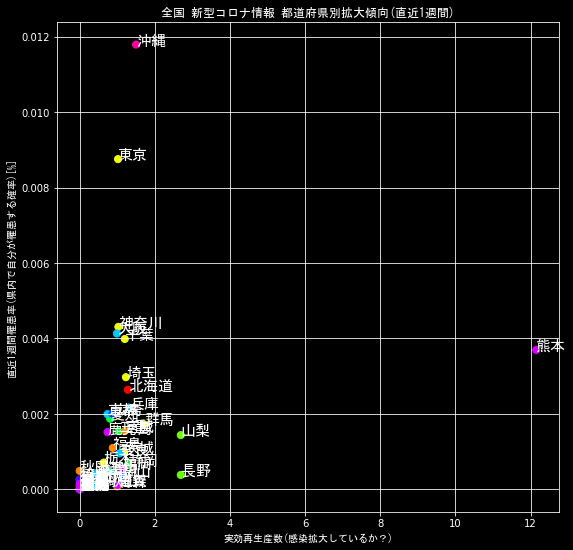

In [19]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近1週間罹患率(県内で自分が罹患する確率)[%]")
cols = [ "#ff0000" for i in range(n_states)]
texts = [ "?" for i in range(n_states)]
for k, v in populations.items():
    cols[v['code'] - 1]  = cm.hsv(v['region'] / 11)
    texts[v['code'] - 1] = v['ja']
plt.scatter(latest_erns[1:], incid1w_rate[1:], s=50, c=cols)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid1w_rate[1 + i]), size=15, fontname=FONT_NAME)
tw_body_1w = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)'
plt.title(tw_body_1w, fontname=FONT_NAME)

show_and_clear(fig, "images/ern-1w_poss.jpg")

In [20]:
def show_zoomed_ern_scatter(
    xbins, ybins, colors, xytexts, nweek, filename, title, xlabel, ylabel,
    n_neighbors=30, n_states=47):
    fig, ax = create_basic_scatter_figure(xlabel, ylabel)
    # LOF
    clf = LocalOutlierFactor(
        n_neighbors=n_neighbors, contamination='auto',
        algorithm='auto', metric='mahalanobis')
    X = np.stack([xbins[1:], ybins[1:]], 1)
    y_pred = clf.fit_predict(X)
    selected_cols = np.array(colors)[y_pred == 1]
    selected_text = np.array(xytexts)[y_pred == 1]
    # append top element
    y_pred = np.append(-1, y_pred)
    selected_xbins = xbins[y_pred == 1]
    selected_ybins = np.array(ybins)[y_pred == 1]
    plt.xlim(0, np.max(selected_xbins))
    plt.ylim(0, np.max(selected_ybins))
    plt.scatter(selected_xbins, selected_ybins, s=50, c=selected_cols)
    for i in np.arange(len(selected_xbins)):
        ax.annotate(selected_text[i], xy=(selected_xbins[i], selected_ybins[i]), size=15, fontname=FONT_NAME)
    plt.title(title, fontname=FONT_NAME)
    show_and_clear(fig, filename)

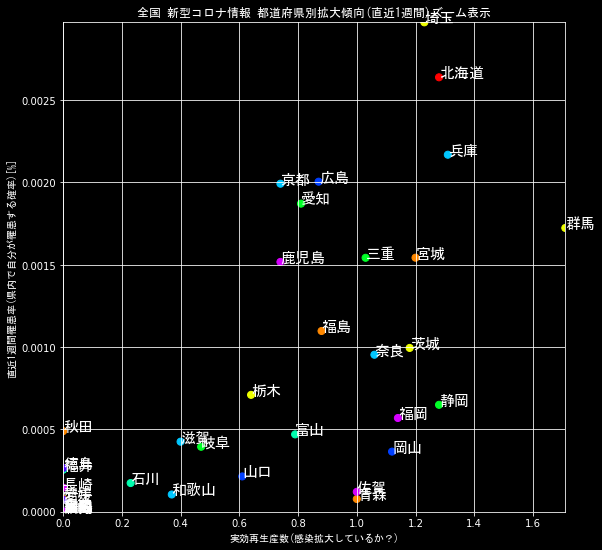

In [21]:
tw_body_1w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)ズーム表示'
show_zoomed_ern_scatter(
    latest_erns, incid1w_rate, cols, texts, 1, "images/ern-1w_poss-zoom.jpg",
    tw_body_1w_zoom,
    "実効再生産数(感染拡大しているか？)",
    "直近1週間罹患率(県内で自分が罹患する確率)[%]")

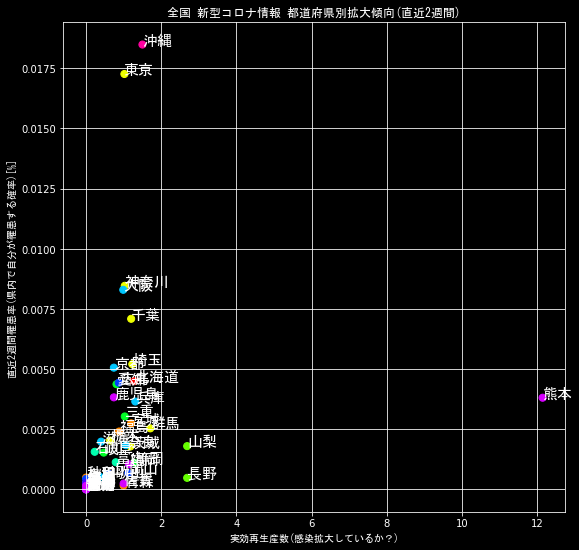

In [22]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近2週間罹患率(県内で自分が罹患する確率)[%]")
plt.scatter(latest_erns[1:], incid2w_rate[1:], s=50, c=cols)
tw_body_2w = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)'
plt.title(tw_body_2w, fontname=FONT_NAME)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid2w_rate[1 + i]), size=15, fontname=FONT_NAME)
show_and_clear(fig, "images/ern-2w_poss.jpg")

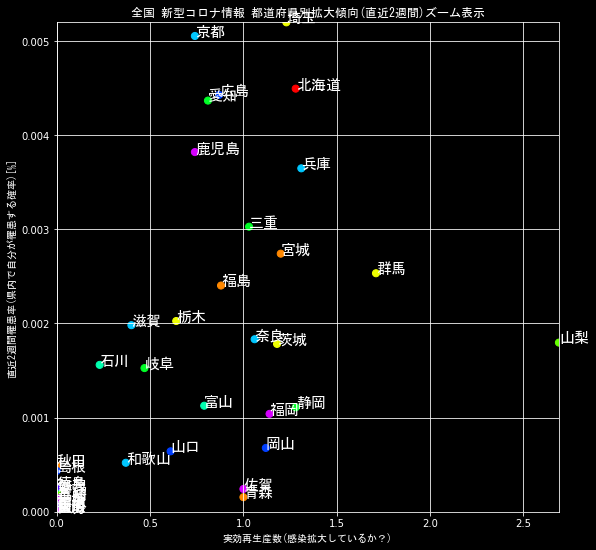

In [23]:
tw_body_2w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)ズーム表示'
show_zoomed_ern_scatter(
    latest_erns, incid2w_rate, cols, texts, 2, "images/ern-2w_poss-zoom.jpg",
    tw_body_2w_zoom,
    "実効再生産数(感染拡大しているか？)",
    "直近2週間罹患率(県内で自分が罹患する確率)[%]")

In [24]:
def mak_japan_heatmap(filename, title, npa1d):
    plt.close()
    plt.style.use("dark_background")
    plt.subplots_adjust(left=0.07, right=0.99, bottom=0.07, top=0.95)
    plt.title(title, fontname=FONT_NAME)
    plt.rcParams['figure.figsize'] = 6, 6
    cmap = plt.get_cmap("Reds")
    norm = plt.Normalize(vmin=np.min(npa1d[1:]), vmax=np.max(npa1d[1:]))
    fcol = lambda x: '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
    plt.colorbar(cm.ScalarMappable(norm, cmap))
    map_cols = {}
    for k, v in populations.items():
        map_cols[v['ja']] = fcol(npa1d[v['code']])
    pict = picture(map_cols)
    plt.imshow(pict)
    plt.savefig(filename)

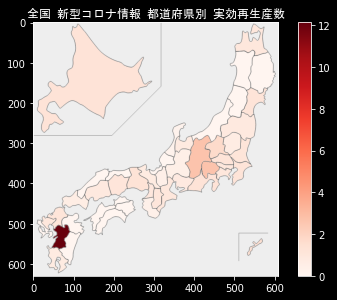

In [25]:
tw_body_map_erns = "全国 新型コロナ情報 都道府県別 実効再生産数"
mak_japan_heatmap('images/japan-erns.jpg', tw_body_map_erns, latest_erns)

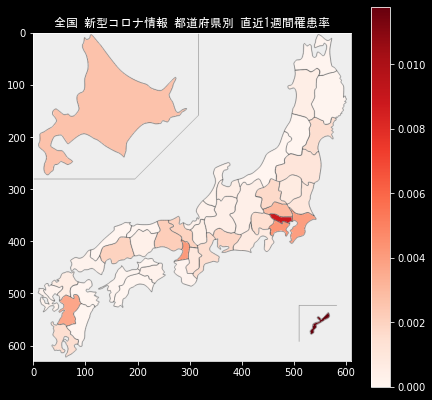

In [26]:
tw_body_map_1w = "全国 新型コロナ情報 都道府県別 直近1週間罹患率"
mak_japan_heatmap('images/japan-1w.jpg', tw_body_map_1w, incid1w_rate)

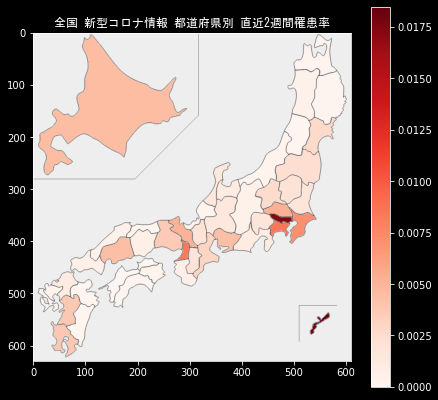

In [27]:
tw_body_map_2w = "全国 新型コロナ情報 都道府県別 直近2週間罹患率"
mak_japan_heatmap('images/japan-2w.jpg', tw_body_map_2w, incid2w_rate)

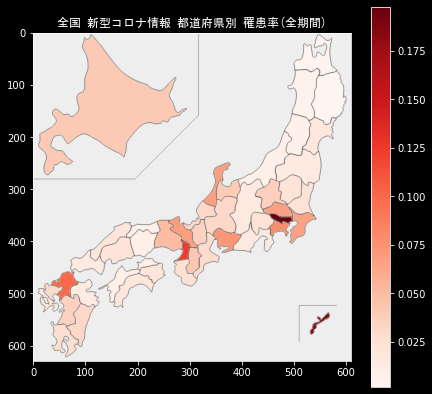

In [28]:
tw_body_map_all = "全国 新型コロナ情報 都道府県別 罹患率(全期間)"
mak_japan_heatmap('images/japan-all.jpg', tw_body_map_all, incid_all_rate)

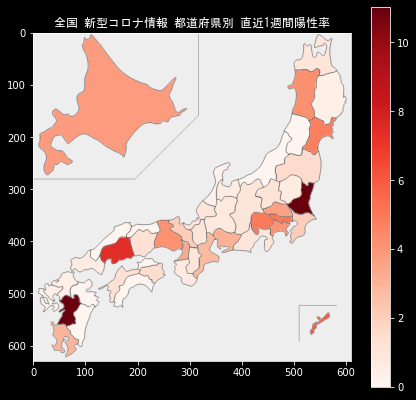

In [29]:
tw_body_map_rate1w = "全国 新型コロナ情報 都道府県別 直近1週間陽性率"
mak_japan_heatmap('images/japan-rate1w.jpg', tw_body_map_rate1w, test1w_rate)

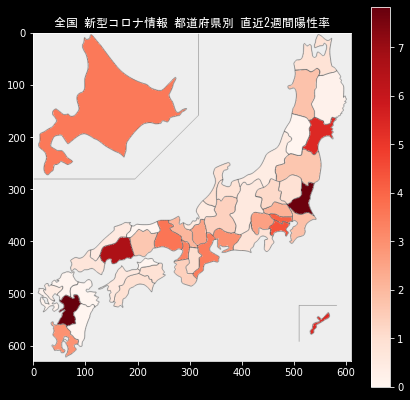

In [30]:
tw_body_map_rate2w = "全国 新型コロナ情報 都道府県別 直近2週間陽性率"
mak_japan_heatmap('images/japan-rate2w.jpg', tw_body_map_rate2w, test2w_rate)

In [31]:
tw = get_twitter()
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body_postfix = " (東洋経済 " + today_str + " 現在)"
#tweet_with_image(tw, "images/ern-1w_poss.jpg", tw_body_1w + tw_body_postfix)
#tweet_with_image(tw, "images/ern-1w_poss-zoom.jpg", tw_body_1w_zoom + tw_body_postfix)
tweet_with_image(tw, "images/ern-2w_poss.jpg", tw_body_2w + tw_body_postfix)
tweet_with_image(tw, "images/ern-2w_poss-zoom.jpg", tw_body_2w_zoom + tw_body_postfix)

In [32]:
tweet_with_image(tw, 'images/japan-erns.jpg', tw_body_map_erns + tw_body_postfix)
#tweet_with_image(tw, 'images/japan-1w.jpg', tw_body_map_1w + tw_body_postfix)
tweet_with_image(tw, 'images/japan-2w.jpg', tw_body_map_2w + tw_body_postfix)
tweet_with_image(tw, 'images/japan-all.jpg', tw_body_map_all + tw_body_postfix)